## Project Description


The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to underage people.

While conducting this evaluation, the following must be kept in mind:
*   The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.
*   Computer vision methods can be used to determine the age of a person from a photo.
*   The task then is to build and evaluate a model for verifying people's age.









## Initialization

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
# load the labels.csv file
labels = pd.read_csv('/content/drive/MyDrive/colab/faces/labels.csv')


## EDA

In [4]:
# preview the data in labels
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


There are 7,591 rows (labels) in our DataFrame. The data types are as expected.

In [6]:
# group real_age by the count of associated files and save it in the ages dataframe
ages = labels.groupby('real_age')['file_name'].count().reset_index()

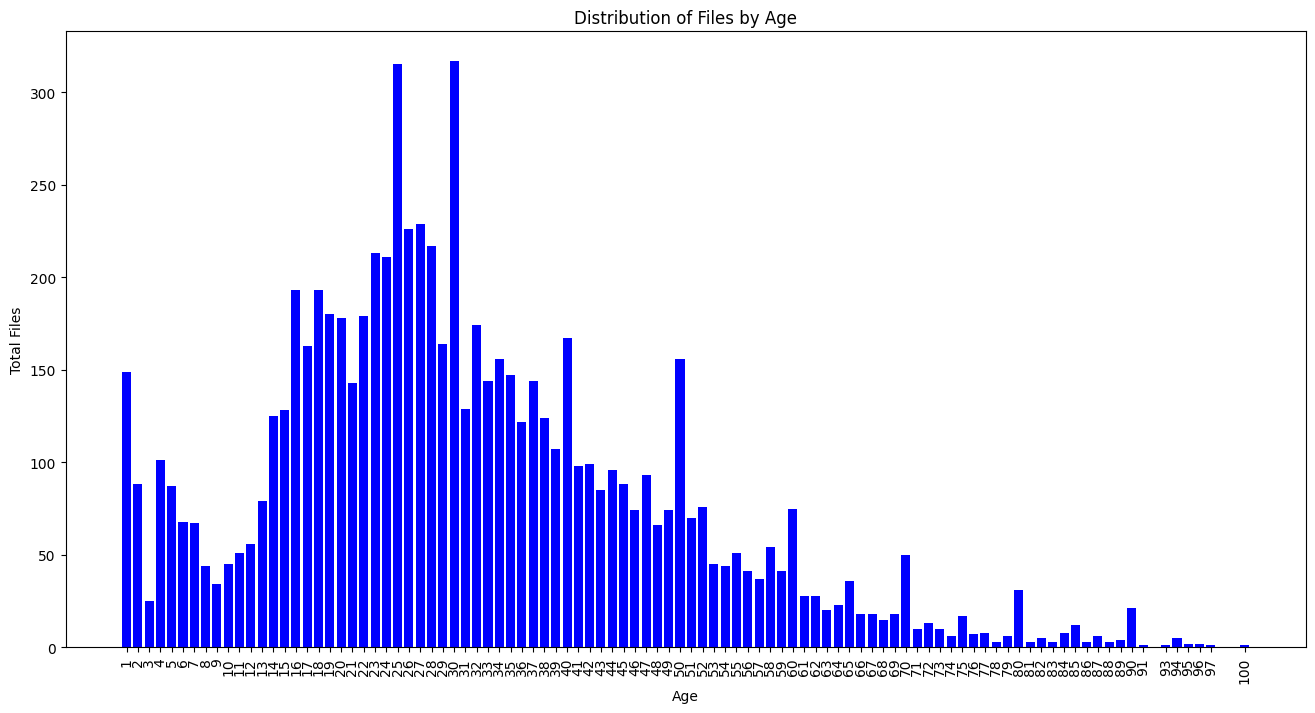

In [7]:
# set the figure size
plt.figure(figsize=(16, 8))

# plot a bar chart of real_age by the count of file names
plt.bar(ages['real_age'], ages['file_name'], color='blue')

# set the plot x-axis and y-axis labels
plt.xlabel('Age')
plt.ylabel('Total Files')

# set the plot title
plt.title('Distribution of Files by Age')

# set the x-ticks and rotate the labels by 90 degrees
plt.xticks(ages['real_age'], rotation=90)

# show the plot
plt.show()

The distribution of photos by age are skewed-left. The greatest concentration of photos are of people ranging from around 16 to 30 years old. This data will be helpful since it's important to train our model with photos of people who are relatively near in age to 21 year olds so we can address the task well.

We have less photos of adolescents and a generally downward trend in the number of photos for ages after 30.

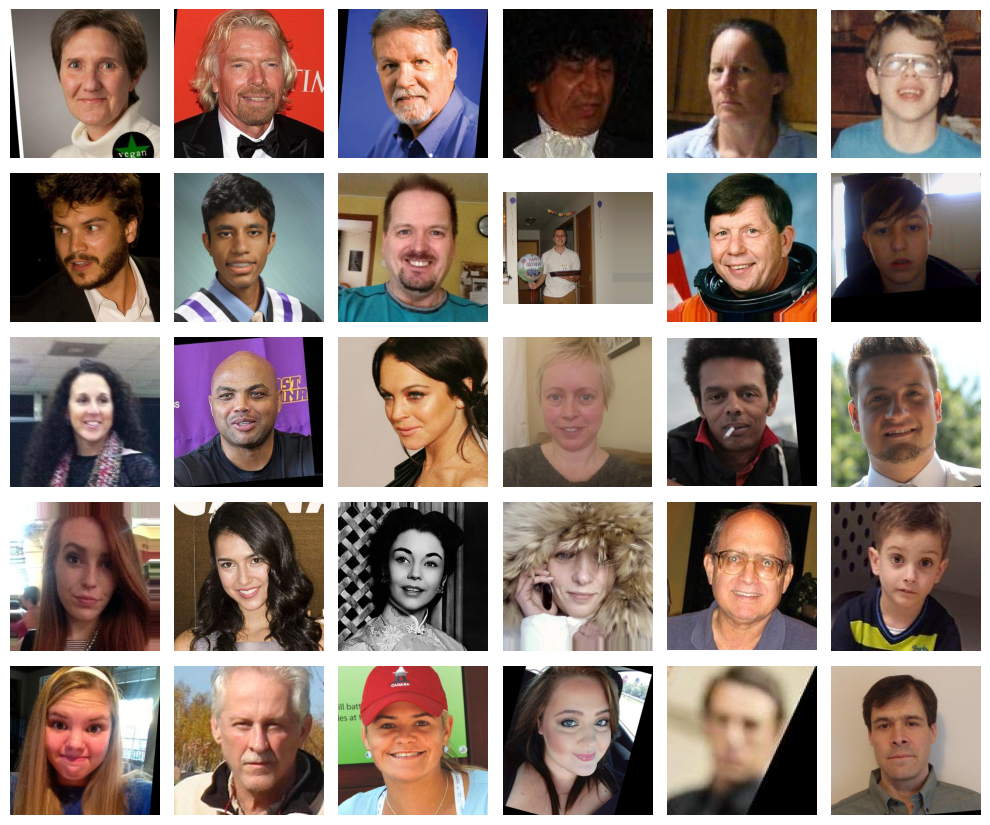

In [8]:
from PIL import Image
import os

# set the figure size
plt.figure(figsize=(10, 10))

# set the number of images to display
num_images = 30

# set the path to the images
path = '/content/drive/MyDrive/colab/faces/final_files/'

# get the list of files in the path
files = os.listdir(path)

# loop through the number of images to display
for i in range(num_images):
    # select a random file
    file = np.random.choice(files)

    # read the image using Pillow
    img = Image.open(os.path.join(path, file))

    # plot the image
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Findings

From the random sample of 15 images displayed, we can observe many things.

The quality of the images vary significantly, and this variability can make the task of predicting age more difficult.

There is also a lot of variation in the image brightness, whether it's in color or is black and white, what the background behind the person is, and what facial expressions they are making, which can impact the model's ability to generalize. Some faces are not cenetered in the photo and are displayed at different angles which induces additional complexity into the model.

Since the age distribution is skewed toward younger people, the model will likely perform better on those age groups. Likely, certain genders and ethnicities are underrepresented in the data set, which may result in model bias (the model performs poorly for these underrepresented groups).





## Modeling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [9]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [10]:
def add_random_noise(image):
    """
    Add random Gaussian noise to an image.

    Parameters:
    image (numpy array): Input image.

    Returns:
    numpy array: Noisy image.
    """
    # Assume the image is in [0, 1] range (ImageDataGenerator rescale can be used)
    noise_factor = 0.1
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=image.shape)
    image_noisy = image + noise

    # Clip the values to be in range [0, 1]
    image_noisy = np.clip(image_noisy, 0.0, 1.0)

    return image_noisy


In [39]:
def load_train(path):

    """
    It loads the train part of dataset from path
    """

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255,
                                        brightness_range=[0.8, 1.2],
                                        horizontal_flip=True,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        rotation_range=10,
                                        shear_range=0.1,
                                        zoom_range=0.3,
                                        fill_mode='nearest',
                                        preprocessing_function=add_random_noise
                                       )


    train_gen_flow = train_datagen.flow_from_dataframe(
       dataframe=labels,
        directory=path + 'final_files/',
       x_col='file_name',
       y_col='real_age',
       target_size=(150, 150),
       batch_size=16,
       class_mode='raw',
       subset='training',
       seed=12345)

    return train_gen_flow

In [40]:
train_gen_flow = load_train('/content/drive/MyDrive/colab/faces/')

Found 1534 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5546 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [41]:
def load_test(path='/content/drive/MyDrive/colab/faces/'):

    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [42]:
test_gen_flow = load_test('/content/drive/MyDrive/colab/faces/')

Found 511 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5546 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [15]:
def create_model(input_shape):

    """
    It defines the model
    """


    backbone = ResNet50(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False
            )

    # freeze ResNet50 with the top removed
    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [16]:
model = create_model((150, 150, 3))

In [43]:
# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [44]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """

    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = int(len(train_data) / batch_size)
    if validation_steps is None:
        validation_steps = int(len(test_data) / batch_size)

    # Check if test_data yields data
    print("Checking test_data...")  # Add a print statement

    try:
        next(test_data)  # Consumes 1 element, check if it works
        print("test_data yielded data successfully.")
    except StopIteration:
        print("test_data is empty or exhausted.")
        return model #or raise an Exception

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[early_stopping],
              verbose=1)

    return model

In [50]:
train_model(model, train_gen_flow, test_gen_flow, epochs=25, batch_size=24)

Checking test_data...
test_data yielded data successfully.
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - loss: 392.9453 - mae: 13.6741 - val_loss: 200.1971 - val_mae: 10.7230
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 493.0246 - mae: 15.8880 - val_loss: 266.8587 - val_mae: 12.3663
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 478.0514 - mae: 16.9678 - val_loss: 301.2936 - val_mae: 11.8827
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 207.6222 - mae: 10.7068 - val_loss: 286.1615 - val_mae: 12.4610
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 349.9650 - mae: 13.2903 - val_loss: 295.8890 - val_mae: 13.8347
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 469.1167 - mae: 15.0079 - val_loss: 174.9939 - val_mae: 11.1395
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 453.6677 - mae: 16.6693 - val_loss: 77.2055 - val_mae: 6.6348
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 276.2411 - mae: 11.6866 - val_l

<Sequential name=sequential, built=True>

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training